In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()
tf.compat.v1.random.set_random_seed(1234)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv('maotai.csv')
df.head()

,Date,股票代码,名称,price,positive,negative
0,2021-11-01,'600519,贵州茅台,1803.00,0.7244,0.2756
1,2021-11-02,'600519,贵州茅台,1804.64,0.7244,0.2756
2,2021-11-03,'600519,贵州茅台,1765.00,0.7244,0.2756
3,2021-11-04,'600519,贵州茅台,1804.20,0.7244,0.2756
4,2021-11-05,'600519,贵州茅台,1819.94,0.7244,0.2756


In [3]:
df=df.drop(labels=['股票代码','名称'],axis=1)

In [4]:
df

,Date,price,positive,negative
0,2021-11-01,1803.00,0.7244,0.2756
1,2021-11-02,1804.64,0.7244,0.2756
2,2021-11-03,1765.00,0.7244,0.2756
3,2021-11-04,1804.20,0.7244,0.2756
4,2021-11-05,1819.94,0.7244,0.2756
...,...,...,...,...
257,2022-11-21,1519.98,0.2264,0.7736
258,2022-11-22,1539.95,0.2264,0.7736
259,2022-11-23,1549.00,0.2264,0.7736
260,2022-11-24,1519.99,0.2264,0.7736


In [5]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:2].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:2].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log[1] = df['positive']
df_log[2] = df['negative']
df_log.head()

,0,1,2
0,0.536672,0.7244,0.2756
1,0.538615,0.7244,0.2756
2,0.491654,0.7244,0.2756
3,0.538094,0.7244,0.2756
4,0.556741,0.7244,0.2756


In [31]:
num_layers = 1
size_layer = 128
epoch = 120
dropout_rate = 0.75
test_size = 2 * 10 # timestamp every 20 minutes, and I want to test on last 12 hours
learning_rate = 1e-4
timestamp = test_size

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((262, 4), (242, 3), (20, 3))

In [32]:
def encoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(
        inp,
        [
            [0, 0],
            [(filter_size[0] - 1) // 2, (filter_size[0] - 1) // 2],
            [0, 0],
            [0, 0],
        ],
    )
    conv = tf.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def decoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(inp, [[0, 0], [filter_size[0] - 1, 0], [0, 0], [0, 0]])
    conv = tf.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def glu(x):
    return tf.multiply(
        x[:, :, : tf.shape(x)[2] // 2],
        tf.sigmoid(x[:, :, tf.shape(x)[2] // 2 :]),
    )


def layer(inp, conv_block, kernel_width, n_hidden, residual = None):
    z = conv_block(inp, n_hidden, (kernel_width, 1))
    return glu(z) + (residual if residual is not None else 0)

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.layers.dense(self.X, size_layer)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            z = layer(
                encoder_embedded,
                encoder_block,
                kernel_size,
                size_layer * 2,
                encoder_embedded,
            )
            z = tf.nn.dropout(z, keep_prob = dropout)
            encoder_embedded = z

        encoder_output, output_memory = z, z + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            attn_res = h = layer(
                encoder_embedded,
                decoder_block,
                kernel_size,
                size_layer * 2,
                residual = tf.zeros_like(encoder_embedded),
            )
            C = []
            for j in range(n_attn_heads):
                h_ = tf.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, keep_prob = dropout)
            encoder_embedded = h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [33]:
#tf.reset_default_graph()
tf.compat.v1.reset_default_graph()
modelnn = Model(
    learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], 
    dropout = dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

C:\Users\ufo\AppData\Local\Temp/ipykernel_23860/3164344384.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, size_layer)
C:\Users\ufo\anaconda3\envs\tensorflow1\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\ufo\AppData\Local\Temp/ipykernel_23860/3164344384.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.layers.conv2d(
C:\Users\ufo\anaconda3\envs\tensorflow1\lib\site-packages\keras\legacy_tf_layers\convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\ufo\Ap

In [34]:
from tqdm import tqdm

los=[]
pbar = tqdm(range(epoch), desc = 'train loop')
for i in pbar:
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss, total_acc = [], []
    for k in range(0, df_train.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_train.shape[0] - 1)
        batch_x = np.expand_dims(
            df_train.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_train.iloc[k + 1 : index + 1, :].values
        logits, _, loss = sess.run(
            [modelnn.logits, modelnn.optimizer, modelnn.cost],
            feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
        )        
        total_loss.append(loss)
        total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    los.append(np.mean(total_loss))
    pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    

train loop: 100%|█████████████████████████████████████████████| 120/120 [00:06<00:00, 18.23it/s, acc=95.9, cost=0.0035]


In [67]:
los

[0.892864,
 0.4674707,
 0.20597863,
 0.089143716,
 0.04709599,
 0.04527805,
 0.048471652,
 0.03464442,
 0.034740712,
 0.0339159,
 0.026713956,
 0.02227332,
 0.02172186,
 0.018008785,
 0.022088906,
 0.017613422,
 0.01650032,
 0.014562092,
 0.014875755,
 0.015682349,
 0.012546946,
 0.015912775,
 0.014013112,
 0.012846699,
 0.011688294,
 0.011359785,
 0.013310801,
 0.012056357,
 0.01061136,
 0.010908593,
 0.013026823,
 0.009707938,
 0.009773238,
 0.008537829,
 0.01005589,
 0.00825523,
 0.009345546,
 0.008344866,
 0.00884443,
 0.008745902,
 0.007795646,
 0.008543351,
 0.008848104,
 0.0082781715,
 0.00866094,
 0.0073469435,
 0.0067309286,
 0.007877188,
 0.008479024,
 0.00777093,
 0.007290339,
 0.005773775,
 0.0067230877,
 0.006680276,
 0.006402349,
 0.007587759,
 0.0064988188,
 0.0063958834,
 0.0062415143,
 0.0059453472,
 0.007290346,
 0.0062281685,
 0.006010486,
 0.0062620337,
 0.0055736583,
 0.0063006347,
 0.005341893,
 0.006143846,
 0.0057293456,
 0.0061634653,
 0.0056093903,
 0.00628214

In [35]:
future_day = test_size

output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
output_predict[0] = df_train.iloc[0]
upper_b = (df_train.shape[0] // timestamp) * timestamp

for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_train.iloc[k : k + timestamp], axis = 0
            )
        },
    )
    output_predict[k + 1 : k + timestamp + 1] = out_logits

if upper_b != df_train.shape[0]:
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
        },
    )
    output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
    future_day -= 1

In [36]:
output_predict_negative = output_predict.copy()
output_predict_positive = output_predict.copy()

In [37]:
for i in range(future_day):
    o = output_predict[-future_day - timestamp + i:-future_day + i].copy()
    o = np.expand_dims(o, axis = 0)
    
    o_negative = output_predict_negative[-future_day - timestamp + i:-future_day + i].copy()
    o_negative = np.expand_dims(o_negative, axis = 0)
    o_negative[:, :, 1] = 0.0
    o_negative[:, :, 2] = 1.0
    
    o_positive = output_predict_positive[-future_day - timestamp + i:-future_day + i].copy()
    o_positive = np.expand_dims(o_positive, axis = 0)
    o_positive[:, :, 1] = 1.0
    o_positive[:, :, 2] = 0.0
    
    # original without any consensus
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: o
        },
    )
    output_predict[-future_day + i] = out_logits[-1]
    
    # negative consensus
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: o_negative
        },
    )
    output_predict_negative[-future_day + i] = out_logits[-1]
    
    # positive consensus
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: o_positive
        },
    )
    output_predict_positive[-future_day + i] = out_logits[-1]

In [38]:
output_predict_original = minmax.inverse_transform(output_predict[:,:1])
output_predict_negative = minmax.inverse_transform(output_predict_negative[:,:1])
output_predict_positive = minmax.inverse_transform(output_predict_positive[:,:1])

In [39]:
deep_future = anchor(output_predict_original[:, 0], 0.7)
deep_future_negative = anchor(output_predict_negative[:, 0], 0.7)
deep_future_positive = anchor(output_predict_positive[:, 0], 0.7)

In [40]:
df.shape, len(deep_future_negative)

((262, 4), 262)

In [41]:
df_train = minmax.inverse_transform(df_train)
df_test = minmax.inverse_transform(df_test)

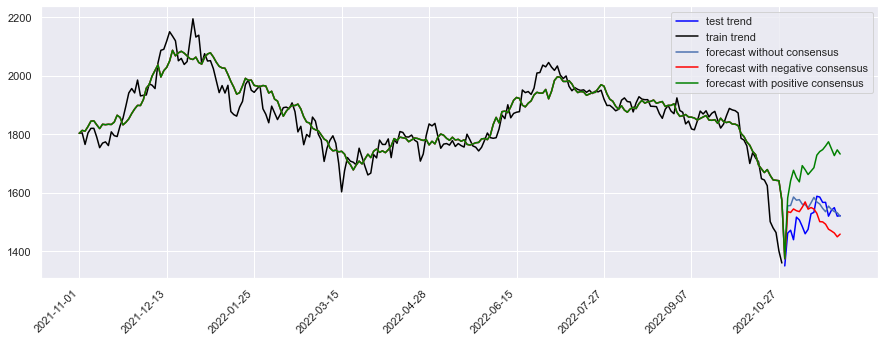

In [58]:
timestamp = df['Date'].tolist()
pad_test = np.pad(df_test[:,0], (df_train.shape[0], 0), 'constant', constant_values=np.nan)

plt.figure(figsize = (15, 5))
plt.plot(pad_test, label = 'test trend', c = 'blue')
plt.plot(df_train[:,0], label = 'train trend', c = 'black')
plt.plot(deep_future, label = 'forecast without consensus')
plt.plot(deep_future_negative, label = 'forecast with negative consensus', c = 'red')
plt.plot(deep_future_positive, label = 'forecast with positive consensus', c = 'green')
plt.legend()
plt.xticks(
    np.arange(len(timestamp))[::30], timestamp[::30], rotation = '45', ha = 'right'
)
plt.show()

In [4]:
ft_list=pd.DataFrame(los,index=range(120),columns=pd.Index(['loss']))

C:\Users\ufo\anaconda3\envs\tensorflow1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='loss'>

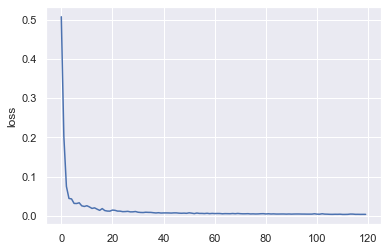

In [10]:
x = np.arange(0, 120)
#plt.xlim(0, 20)
plt.tight_layout()
sns.lineplot(x, y='loss',data=ft_list)

C:\Users\ufo\anaconda3\envs\tensorflow1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='loss'>

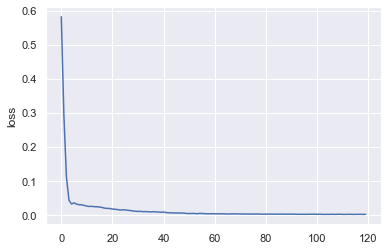

In [13]:
ft_list=pd.DataFrame(los1,index=range(120),columns=pd.Index(['loss']))
x = np.arange(0, 120)
#plt.xlim(0, 20)
plt.tight_layout()
sns.lineplot(x, y='loss',data=ft_list)

In [65]:
df = pd.DataFrame(lis)
df['lis1']=lis_1
df['lis2']=lis_2
df['orig1']=abs(df['lis2']-df[0])
df['orig']=abs(df['lis1']-df[0])
df=df.drop([0,'lis1','lis2'],axis=1)
df.rename(columns={'orig':'with em_score','orig1':'without em_score'},inplace=True)

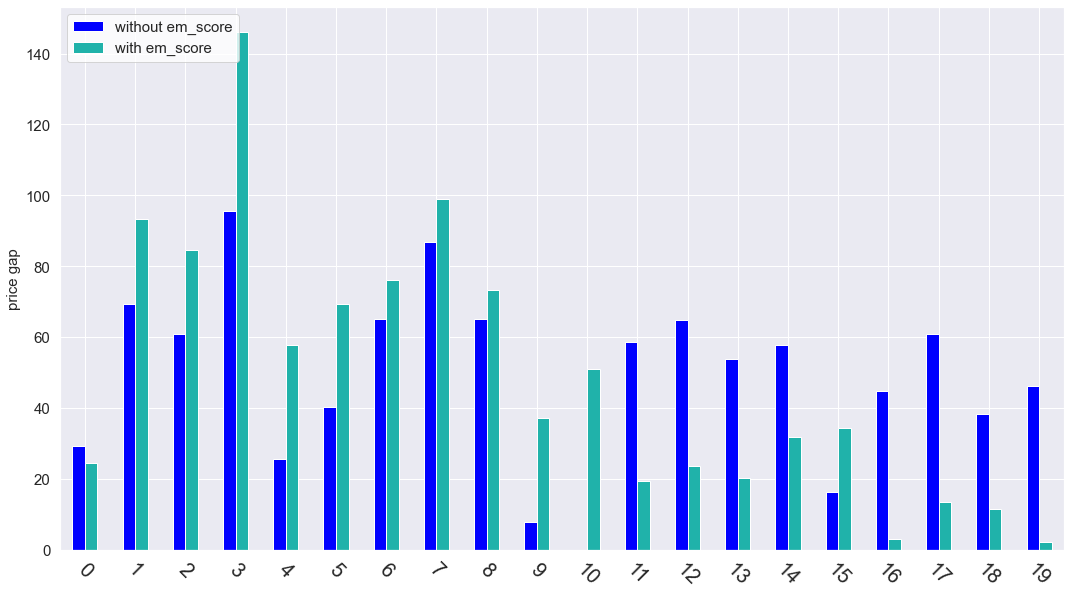

In [66]:
fig, ax = plt.subplots()

with sns.axes_style("whitegrid"):
    df.plot(kind='bar',figsize=(18,10),legend='upper center',color = ['blue', 'lightseagreen'], ax=ax)
    ax.legend(loc='upper left',fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=20, labelrotation=315)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel='price gap',fontsize=15)